<a href="https://colab.research.google.com/github/redrosesarecool/model-w-ML/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd

file_path = '/content/drive/MyDrive/dane_obserwacyjne-kopia.dat'

col_names = ['R','err_R','D','err_D','l','b','x','y','z','vx','vRt','err_vRt','vz','wc','delta_wc','Reference']

# delim_whitespace=True -> oddzielone spacjami lub tabami
dane_df = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=col_names)

print(dane_df.head())

# przykładowe tensory do PINN
import torch
R_tensor = torch.tensor(dane_df['R'].values, dtype=torch.float32).unsqueeze(1)
v_tensor = torch.tensor(dane_df['vRt'].values, dtype=torch.float32).unsqueeze(1)

/tmp/ipython-input-1320893702.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dane_df = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=col_names)


       R  err_R      D  err_D     l    b      x      y    z       vx      vRt  \
0  2.159  0.041  8.056  0.155  15.0  0.0  0.559 -2.085  0.0  794.078  205.522   
1  2.299  0.044  8.017  0.154  16.0  0.0  0.634 -2.210  0.0  727.687  200.578   
2  2.438  0.047  7.976  0.153  17.0  0.0  0.713 -2.332  0.0  671.798  196.415   
3  2.577  0.049  7.932  0.152  18.0  0.0  0.796 -2.451  0.0  639.551  197.632   
4  2.715  0.052  7.886  0.151  19.0  0.0  0.884 -2.567  0.0  605.491  197.129   

   err_vRt    vz      wc  delta_wc     Reference  
0      4.5  7.81  95.213     2.085  Fich89_Table  
1      4.5  7.81  87.253     1.958  Fich89_Table  
2      4.5  7.81  80.551     1.845  Fich89_Table  
3      4.5  7.81  76.685     1.746  Fich89_Table  
4      4.5  7.81  72.601     1.657  Fich89_Table  


Wypłaszczone dane zapisano do dane_wyplaszczone.dat
     R_mean      v_mean      v_std
0  0.715667  284.596000  97.292414
1  1.068000  212.138000        NaN
2  1.460714  159.310714  55.025487
3  1.728455  186.597545  15.484593
4  2.057083  188.832000  42.230488
5  2.340406  200.541844  27.632671
6  2.634487  206.277410  17.156684
7  2.950000  212.392081  10.085922
8  3.239762  217.078737   9.529129
9  3.550937  221.852354   6.536144


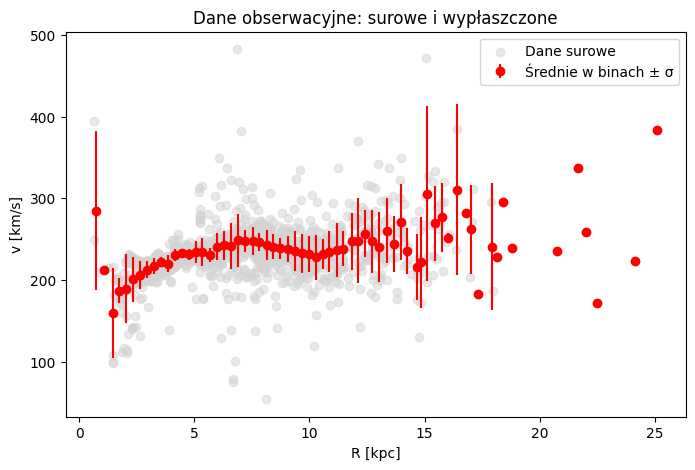

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Dane
# -----------------------------
R_raw = dane_df['R'].values          # kpc
v_obs_raw = dane_df['vRt'].values    # km/s

# -----------------------------
# 2️⃣ Wypłaszczenie danych (biny)
# -----------------------------
# Zwiększona liczba binów
n_bins = 80

# Tworzymy biny po R
bins = np.linspace(R_raw.min(), R_raw.max(), n_bins + 1)

# Tworzymy DataFrame dla wygody
df = pd.DataFrame({'R': R_raw, 'v': v_obs_raw})
df['bin'] = np.digitize(df['R'], bins)

# Średnia i odchylenie w każdym binie
v_mean = df.groupby('bin')['v'].mean().values
v_std = df.groupby('bin')['v'].std().values
R_mean = df.groupby('bin')['R'].mean().values

# -----------------------------
# 3️⃣ Zapis do nowego pliku
# -----------------------------
wyp_plik = 'dane_wyplaszczone.dat'
wyp_df = pd.DataFrame({'R_mean': R_mean, 'v_mean': v_mean, 'v_std': v_std})
wyp_df.to_csv(wyp_plik, sep='\t', index=False)
print(f"Wypłaszczone dane zapisano do {wyp_plik}")

# -----------------------------
# 4️⃣ Wyświetlenie fragmentu danych
# -----------------------------
print(wyp_df.head(10))  # pierwsze 10 wierszy

# -----------------------------
# 5️⃣ Wykres surowe dane + wypłaszczone
# -----------------------------
plt.figure(figsize=(8,5))
plt.scatter(R_raw, v_obs_raw, color='lightgray', alpha=0.5, label='Dane surowe')
plt.errorbar(R_mean, v_mean, yerr=v_std, fmt='o', color='red', label='Średnie w binach ± σ')
plt.xlabel('R [kpc]')
plt.ylabel('v [km/s]')
plt.title('Dane obserwacyjne: surowe i wypłaszczone')
plt.legend()
plt.show()

In [26]:
import torch

def besselj1_torch(x):
    """
    Aproksymacja Bessel J1 działająca w 100% w torch
    (autograd-friendly, bez numpy).
    """
    x = torch.as_tensor(x, dtype=torch.float32)

    # małe argumenty -> rozwinięcie szeregu Taylora
    small = x.abs() < 1e-2
    large = ~small

    result = torch.zeros_like(x)

    # J1(x) ≈ x/2 - x³/16 + x⁵/384
    xx = x[small]
    result[small] = xx/2 - xx**3/16 + xx**5/384

    # duże argumenty -> asymptotyka
    # J1(x) ≈ sqrt(2/(πx)) * cos(x - 3π/4)
    xl = x[large]
    result[large] = torch.sqrt(2/(torch.pi*xl)) * torch.cos(xl - 3*torch.pi/4)

    return result

Epoch 0, Loss: 1247761408.000000
Epoch 5000, Loss: 14690231.000000
Epoch 10000, Loss: 1268441.875000
Epoch 15000, Loss: 86942.742188
Epoch 20000, Loss: 8620.895508
Epoch 25000, Loss: 858.902649
Epoch 30000, Loss: 43.806774
Epoch 35000, Loss: 3.865986
Epoch 40000, Loss: 0.342540
Epoch 45000, Loss: 0.064570
Epoch 50000, Loss: 0.031922
Epoch 55000, Loss: 0.015730
Epoch 60000, Loss: 0.008604
Epoch 65000, Loss: 0.005477
Epoch 70000, Loss: 0.004102
Epoch 75000, Loss: 0.003497
Epoch 80000, Loss: 0.003232
Epoch 85000, Loss: 0.003115
Epoch 90000, Loss: 0.003075


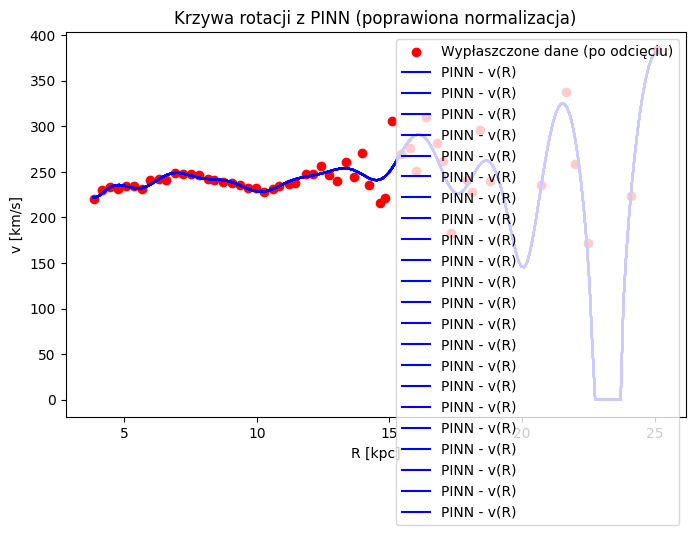

In [36]:
import numpy as np
import pandas as pd
import torch
from scipy.special import jn_zeros, j1
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Wczytanie wypłaszczonych danych
# -----------------------------
wyp_df = pd.read_csv('dane_wyplaszczone.dat', sep='\t')

# Odcięcie pierwszych 10 punktów
wyp_df_cut = wyp_df.iloc[10:].reset_index(drop=True)
R_mean = wyp_df_cut['R_mean'].values
v_mean = wyp_df_cut['v_mean'].values

# -----------------------------
# 2️⃣ Normalizacja danych
# -----------------------------
R_scale = R_mean.max()       # np. 15 kpc
v_scale = v_mean.max()       # np. 250 km/s

R_train_scaled = torch.tensor(R_mean / R_scale, dtype=torch.float32).unsqueeze(1)
v_train_scaled = torch.tensor(v_mean / v_scale, dtype=torch.float32).unsqueeze(1)

# -----------------------------
# 3️⃣ Parametry PINN
# -----------------------------
N = 22  # liczba składników sumy Bessela
z0 = 0.0  # płaszczyzna z=0

# pierwiastki J0
lambda_n_raw = jn_zeros(0, N)
lambda_n = torch.tensor(lambda_n_raw, dtype=torch.float32).unsqueeze(0)

# Parametry A_n (log-transform, większa inicjalizacja)
logA = torch.nn.Parameter(torch.randn(N, 1) * 6.0)  # większa inicjalizacja
optimizer = torch.optim.Adam([logA], lr=1e-3)

# -----------------------------
# 4️⃣ Funkcja predykcji v^2
# -----------------------------
def v2_pred(R, logA, lambda_n, z=0.0):
    A = torch.exp(logA)  # zawsze >0
    R_mat = R.repeat(1, N)
    lambda_mat = lambda_n.repeat(R.shape[0], 1)

    J1_val = torch.tensor(j1(lambda_mat.detach().numpy() * R_mat.detach().numpy()), dtype=torch.float32)

    v2 = R_mat * torch.matmul(J1_val * lambda_mat, A) * torch.exp(-lambda_mat * z)
    return v2

# -----------------------------
# 5️⃣ Training loop
# -----------------------------
epochs = 95000
for epoch in range(epochs):
    optimizer.zero_grad()
    v2 = v2_pred(R_train_scaled, logA, lambda_n, z=z0)

    # Loss trenowany na znormalizowany v²
    loss = ((v2 - v_train_scaled**2)**2).mean()
    loss.backward()
    optimizer.step()

    if epoch % 5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# -----------------------------
# 6️⃣ Wykres krzywej rotacji (odwrócenie normalizacji)
# -----------------------------
R_test_scaled = torch.linspace(R_train_scaled.min(), R_train_scaled.max(), 200).unsqueeze(1)
v_test_scaled = torch.sqrt(torch.relu(v2_pred(R_test_scaled, logA, lambda_n, z=z0)))

R_test_phys = R_test_scaled * R_scale
v_test_phys = v_test_scaled * v_scale

plt.figure(figsize=(8,5))
plt.scatter(R_mean, v_mean, color='red', label='Wypłaszczone dane (po odcięciu)')
plt.plot(R_test_phys.detach().numpy(), v_test_phys.detach().numpy(), color='blue', label='PINN - v(R)')
plt.xlabel('R [kpc]')
plt.ylabel('v [km/s]')
plt.title('Krzywa rotacji z PINN (poprawiona normalizacja)')
plt.legend()
plt.show()


Epoch 0, Loss: 176743743488.000000
Epoch 5000, Loss: 2928188160.000000
Epoch 10000, Loss: 256787408.000000
Epoch 15000, Loss: 19955178.000000
Epoch 20000, Loss: 1071287.875000
Epoch 25000, Loss: 173341.546875
Epoch 30000, Loss: 6989.298340
Epoch 35000, Loss: 552.333496
Epoch 40000, Loss: 79.693520
Epoch 45000, Loss: 14.078437
Epoch 50000, Loss: 6.700634
Epoch 55000, Loss: 2.971971
Epoch 60000, Loss: 1.305437
Epoch 65000, Loss: 0.574732
Epoch 70000, Loss: 0.253947
Epoch 75000, Loss: 0.113257
Epoch 80000, Loss: 0.051460
Epoch 85000, Loss: 0.024301
Epoch 90000, Loss: 0.012369


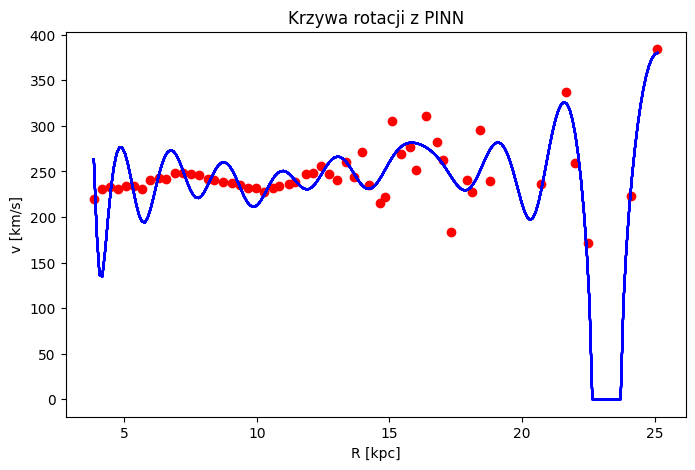

In [37]:
import numpy as np
import pandas as pd
import torch
from scipy.special import jn_zeros, j1
import matplotlib.pyplot as plt


# Wczytanie wypłaszczonych danych

wyp_df = pd.read_csv('dane_wyplaszczone.dat', sep='\t')

# Odcięcie pierwszych 10 punktów
wyp_df_cut = wyp_df.iloc[10:].reset_index(drop=True)
R_mean = wyp_df_cut['R_mean'].values
v_mean = wyp_df_cut['v_mean'].values


# Normalizacja danych

R_scale = R_mean.max()       # np. 15 kpc
v_scale = v_mean.max()       # np. 250 km/s

R_train_scaled = torch.tensor(R_mean / R_scale, dtype=torch.float32).unsqueeze(1)
v_train_scaled = torch.tensor(v_mean / v_scale, dtype=torch.float32).unsqueeze(1)


# Parametry PINN

N = 22  # liczba składników sumy Bessela
z0 = 0.0  # płaszczyzna z=0

# pierwiastki J0
lambda_n_raw = jn_zeros(0, N)
lambda_n = torch.tensor(lambda_n_raw, dtype=torch.float32).unsqueeze(0)

# Parametry A_n (log-transform, większa inicjalizacja)
logA = torch.nn.Parameter(torch.randn(N, 1) * 6.0)  # większa inicjalizacja
optimizer = torch.optim.Adam([logA], lr=1e-3)


# Funkcja predykcji v^2

def v2_pred(R, logA, lambda_n, z=0.0):
    A = torch.exp(logA)  # zawsze >0
    R_mat = R.repeat(1, N)
    lambda_mat = lambda_n.repeat(R.shape[0], 1)

    J1_val = torch.tensor(j1(lambda_mat.detach().numpy() * R_mat.detach().numpy()), dtype=torch.float32)

    v2 = R_mat * torch.matmul(J1_val * lambda_mat, A) * torch.exp(-lambda_mat * z)
    return v2


# Training loop

epochs = 95000
for epoch in range(epochs):
    optimizer.zero_grad()
    v2 = v2_pred(R_train_scaled, logA, lambda_n, z=z0)

    # Loss trenowany na znormalizowany v²
    loss = ((v2 - v_train_scaled**2)**2).mean()
    loss.backward()
    optimizer.step()

    if epoch % 5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Wykres krzywej rotacji (odwrócenie normalizacji)

R_test_scaled = torch.linspace(R_train_scaled.min(), R_train_scaled.max(), 200).unsqueeze(1)
v_test_scaled = torch.sqrt(torch.relu(v2_pred(R_test_scaled, logA, lambda_n, z=z0)))

R_test_phys = R_test_scaled * R_scale
v_test_phys = v_test_scaled * v_scale

plt.figure(figsize=(8,5))
plt.scatter(R_mean, v_mean, color='red', label='Wypłaszczone dane (po odcięciu)')
plt.plot(R_test_phys.detach().numpy(), v_test_phys.detach().numpy(), color='blue', label='PINN - v(R)')
plt.xlabel('R [kpc]')
plt.ylabel('v [km/s]')
plt.title('Krzywa rotacji z PINN')
plt.show()
